# Impact of the Thomas Fire on AQI in Santa Barbara County, CA (2017)

Author: Oksana Protsukha

Github repository: https://github.com/oksanaprotsukha/thomasfire_aqi_analysis


### Table of Contents

- [Overview](#section-1-overview)
- [Data](#section-2-data)
- [Final Output](#section-3-final_output)
- [Import Libraries](#section-4-import_libraries)
- [Import Data](#section-5-import_data)
    - [Import AQI data](#section-5.1-import_aqi)
    - [Import lansat raster data](#section-5.2-import_lsat)
    - [Import California fire perimeter shape file](#section-5.3-import_shape)
- [Prepare AQI Data](#section-6-prep_aqi)
- [Visualize AQI output](#section-7-plot_aqi)
- [Prepare geospatial data](#section-8-prep_geodata)
- [Create a map](#section-9-map)

## Overview <a id="section-1-overview"></a>
In this notebook, we are going to analyze the impact of [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire)  on the air quality in Santa Barbara county in 2017. To do so, we will complete the following two tasks:
1. Visualize the Air Quality Index (AQI) in Santa Barbara County for 2017 and 2018.
2. Create a map to visualize the Thomas Fire scar.

### Purpose <a id="section-1.1-purpose"></a>
The primary purpose of the notebook is to demonstrate environmental data analysis methods using both vector and raster data.

### Tools <a id="section-1.2-tools"></a>
- Python libraries
    - `numpy`
    - `pandas`
    - `pyplot` and `patches` from `matplotlib`
    - `rioxarray`
    - `geopandas`
    - `xarray`
- Jupyter Notebook
- GitHub

### Highlights <a id="section-1.3-highlights"></a>
- Data wrangling and exploration with `Pandas`
- Geospatial data wrangling with `GeoPandas` and `Rioxarray`
- Time series analysis
- Merging tabular and vector data
- Visualizing analysis results with a line plot
- Creating and customizing a map with raster and vector data

### About the data <a id="section-2-data"></a>

#### DataSet 1
[Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov)[1] to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County [2]. 

#### DataSet 2
A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite [3]. **Note**: data should be used for visualization purposes only. 

Information about Landsat bands from USGS:

- [What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)</br>
- [Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)</br>
- [How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)</br>

#### DataSet 3
A prepared shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)[4].

**Data for datasets 2 and 3 is available on Google Drive in the file** [thomasfire_aqi_analysis.zip](https://drive.google.com/file/d/1lDBPBy9378Zcj1g9Huhe8F_WeP4LZ7CN/view?usp=sharing). 

## Final Output <a id="section-3-final_output"></a>
The final outputs of the analysis include:

- A **Line Plot** depicting the time series analysis of the Air Quality Index (AQI) in Santa Barbara for 2017 and 2018.</br>
<img src="assets/thomas_fire_aqi.png" width="800" />

- A **Map** with an overlay of the Thomas Fire scar on the Santa Barbara land cover.</br>
<img src="assets/thomas_fire_scar.png" width="800" />

### Citations:
[1] AirData Website File Download Page. https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023.<br>
[2] “Thomas Fire.” Wikipedia, 9 Nov. 2023. Wikipedia, https://en.wikipedia.org/w/index.php?title=Thomas_Fire&oldid=1184323284.<br>
[3] Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.<br>
[4] California Fire Perimeters (All). https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023.

## Import Libraries <a id="section-4-import_libraries"></a>

In [1]:
# import libraries with standard abbreviations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import rioxarray as rioxr
import geopandas as gpd
import xarray as xr

## Import Data <a id="section-5-import_data"></a>

#### Import Air quality data <a id="section-5.1-import_aqi"></a>

In [2]:
# import Daily AQI by County data from url: Dataset 1
# read in 2017 Daily AQI by County
url_aqi_17 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip'
aqi_17 = pd.read_csv(url_aqi_17)

# read in 2018 Daily AQI by County
url_aqi_18 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip'
aqi_18 = pd.read_csv(url_aqi_18)

#### Import Landsat geospatial data (netCDF) <a id="section-5.2-import_lsat"></a>

In [3]:
# use rioxarray library to import netCDF file with geospatial features
fp_lsat = 'data/landsat8-2018-01-26-sb-simplified.nc'
lsat = rioxr.open_rasterio(fp_lsat)

#### Import California fire perimeter shape file <a id="section-5.2-import_shape"></a>

In [4]:
# use geopandas to import shape file with California fire perimeters 
calfire = gpd.read_file(os.path.join(os.getcwd(), 'data', 
                                     'California_Fire_Perimeters_2017',
                                     'California_Fire_Perimeters_2017.shp'))  

## Prepare Air quality data <a id="section-6-prep_aqi"></a>

Let's take a quick look at the data before we proceed with data wrangling steps. 

In [5]:
# view the list of columns 
print(aqi_17.columns)

# view the first 2 rows of the dataframe aqi_17
aqi_17.head(2)

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1


In [6]:
# view the list of columns 
print(aqi_18.columns)

# view the first 2 rows of the dataframe aqi_18
aqi_18.head(2)

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')


,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,32,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,34,Good,PM2.5,01-003-0010,1


Notice that we currently have two separate dataframes. However, in order to analyze AQI for the two years, we need to combine them by appending the rows from one dataframe on top of the other. 
We will use the pandas function `pd.concat()` to do so. 

**Important**: the columns of the two datasets have to match.

In [7]:
# check whether the columns between the two datasets match
print(f'Do columns match?\n {aqi_18.columns == aqi_17.columns} \n')

# check whether the column datatypes between the two datasets match
print(f'Do datatypes of the columns match?\n{aqi_18.dtypes == aqi_17.dtypes}')

Do columns match?
 [ True  True  True  True  True  True  True  True  True  True] 

Do datatypes of the columns match?
State Name                   True
county Name                  True
State Code                   True
County Code                  True
Date                         True
AQI                          True
Category                     True
Defining Parameter           True
Defining Site                True
Number of Sites Reporting    True
dtype: bool


**Note**: since the column names and datatypes of the two datasets match exaclty we can combine the them into a single dataframe.
Let's check how many records we should expect in the combined dataframe.

In [8]:
# get the count of rows that have state = CA and county = Santa Barbara in the dataframe aqi_17
aqi_17_count = len(aqi_17)

# get the count of rows that have state = CA and county = Santa Barbara in the dataframe aqi_18
aqi_18_count = len(aqi_18)

# get the total count of rows we expect in the combined dataframe
tot_count = aqi_17_count + aqi_18_count
print(f'Combined dataframe should have total number of rows: {tot_count}')  

Combined dataframe should have total number of rows: 654338


In [9]:
# combine two datasets aqi_17 and aqi_18 in a single one
aqi = pd.concat([aqi_17, aqi_18])

# check the total count of rows matches the expected number
aqi_count = len(aqi)
print(f'Count of rows in the combined aqi dataframe: {aqi_count}')
print(f'Is the total number of rows in the combined dataframe as expected? {aqi_count == tot_count} \n')

# check the first 2 rows of the combined dataframe
aqi.head(2)

Count of rows in the combined aqi dataframe: 654338
Is the total number of rows in the combined dataframe as expected? True 



,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1


Notice that column names have inconsistent case and spaces in between the words. 
Let's update the column names to `snake_case` 🐍 to simplify data manipulation.

In [10]:
# update the column names case to snake_case
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')
# check that the column names are updated
print(aqi.columns)

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')



For our analysis we need only AQI data from the Santa Barbara county. 
Let's create a new dataframe` aqi_sb ` filtered to Santa Barbara county. Additionally, we can remove unecessary columns state_name, county_name, state_code and county_code from the new dataframe. 

In [11]:
# select the records where county_name = 'Santa Barbara' from the combined dataset aqi
aqi_sb = aqi.loc[aqi.county_name == 'Santa Barbara'].copy()

# remove the state_name, county_name, state_code and county_code columns from aqi_sb
aqi_sb = aqi_sb.drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])

In [12]:
# check the data types of the columns
print(aqi_sb.dtypes)

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object


⚠️ Date column has type `object` rather than `datetime` as expected. 

We will make the following changes to facilitate working with dates:

- Convert the date column of aqi_sb to a `datetime` object.
- Set the date column as the `index` for aqi_sb dataframe.

In [13]:
# update date column values of aqi_sb to datetype object
aqi_sb.date = pd.to_datetime(aqi_sb.date)
      
# update the index of aqi_sb to be the date column
aqi_sb = aqi_sb.set_index('date')

# check column date is updated
print(aqi_sb.index)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)


Our current dataframe contains daily values of AQI, which can create short-term fluctuations and noise in data. We'll apply a 5-day rolling average to smooth out the data and improve the quality of the analysis. To achieve this we will create a new variable, five_day_average, using the [pandas method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) `rolling`.

**Note**: 
`rolling()` is a method for `pandas.series` that provides rolling window calculations. This is a lazy method (think groupby), we need to specify what we want to calculate over each window. It returns `pd.Series` as ouput.

In [14]:
# calculate 5-day rolling average AQI
# the parameter '5D' indicates we want the window to be 5 days
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean() 

# view the first two rows of the updated dataframe
aqi_sb.head(2)

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.0
2017-01-02,36,Good,Ozone,06-083-4003,11,37.5


## Visualize AQI output <a id="section-7-plot_aqi"></a>
In the next step, we will create a line plot with daily AQI and 5-day average AQI to visualize the impact of the Thomas Fire (December 2017) on air quality in Santa Barbara County.

<function matplotlib.pyplot.show(close=None, block=None)>

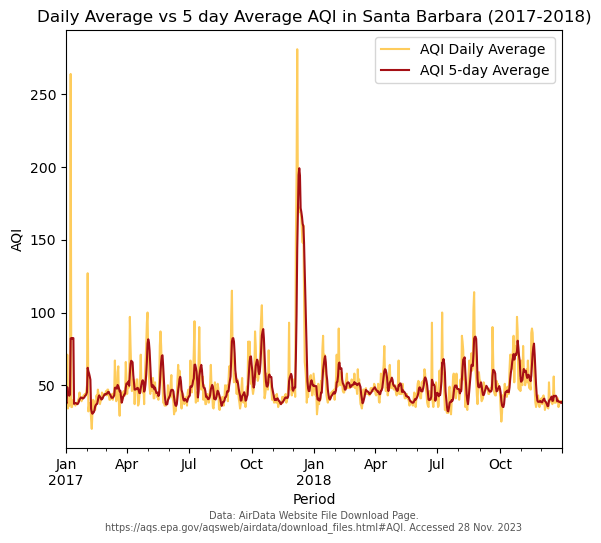

In [15]:
# plot both the daily AQI and the 5-day average
fig, ax = plt.subplots()

aqi_sb.aqi.plot(ax=ax,
                color = '#fecc5c')
aqi_sb.five_day_average.plot(ax=ax,
                color = '#a50f15')

# update axis
ax.set_title('Daily Average vs 5 day Average AQI in Santa Barbara (2017-2018)')
ax.set_xlabel('Period')
ax.set_ylabel('AQI')
ax.legend(['AQI Daily Average', 'AQI 5-day Average'])

# Annotate the data source
ax.annotate("Data: AirData Website File Download Page.\nhttps://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023",
            xy=(0.5, -0.15),  # Move the annotation lower to leave space for the x-axis title
            fontsize=7, 
            xycoords='axes fraction',  
            color='#555555',
            ha='center',
            va='top')  

# Adjust the layout to leave space for the x-axis title
plt.subplots_adjust(bottom=0.01)

plt.show

From the graph we can see a significant increase in both the daily average and 5-day rolling average in December 2017 compared to the rest of the year, which coincides with the Thomas Fire event. During this period, the AQI exceeded 200, falling into the **very unhealthy** category. According to AQI standards, at this level, the risk of health effects is increased for everyone.

## Prepare geospatial data <a id="section-8-prep_geodata"></a>

First, let's inspect geospatial datasets.

In [16]:
# view the first two records of imported shape file data
calfire.head(2)

,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,...,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."


calfire dataset shape: (608, 23)
calfire dataset crs: epsg:3857
calfire dataset geometry:
 0    POLYGON ((-13229812.974 4046876.486, -13229786...
1    POLYGON ((-13286872.985 4074523.355, -13286895...
2    POLYGON ((-13244637.580 4056332.530, -13244620...
3    POLYGON ((-13229521.754 4046254.111, -13229510...
4    POLYGON ((-13229663.036 4046858.853, -13229667...
Name: geometry, dtype: geometry


<AxesSubplot:>

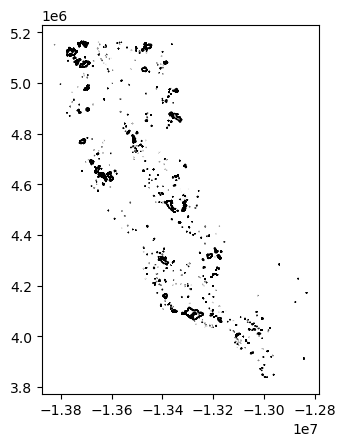

In [17]:
print(f'calfire dataset shape: {calfire.shape}')
print(f'calfire dataset crs: {calfire.crs}')
print(f'calfire dataset geometry:\n {calfire.geometry.head()}')

# visualize calfire data
calfire.plot(color = 'none')

California fire perimeter dataset includes the list of all fires in California during 2017. 
For our analysis, we are interested only in Thomas fire that occured that year.

Therefore, we need to filter the dataset to the rows with Thomas fire.

In [18]:
# update the column names case to snake_case
calfire.columns = calfire.columns.str.lower().str.replace(' ','_')
print(calfire.columns)

# find the value that corresponds to Thomas fire
calfire[calfire.fire_name.str.contains('Thomas', case=False, na=False)]['fire_name'].unique()

Index(['index', 'objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'c_method', 'objective',
       'gis_acres', 'comments', 'complex_na', 'complex_in', 'irwinid',
       'fire_num', 'decades', 'shape_leng', 'shape_area', 'geometry'],
      dtype='object')


array(['THOMAS'], dtype=object)

We only have one record with fire_name = THOMAS. This is the record that we want to use for our analysis. 

In [19]:
# create a new dataframe with Thomas fire details
tf = calfire[calfire.fire_name == 'THOMAS']

lsat CRS: EPSG:32611
shape:  (731, 870)
data type:  <class 'xarray.core.dataset.Dataset'> 



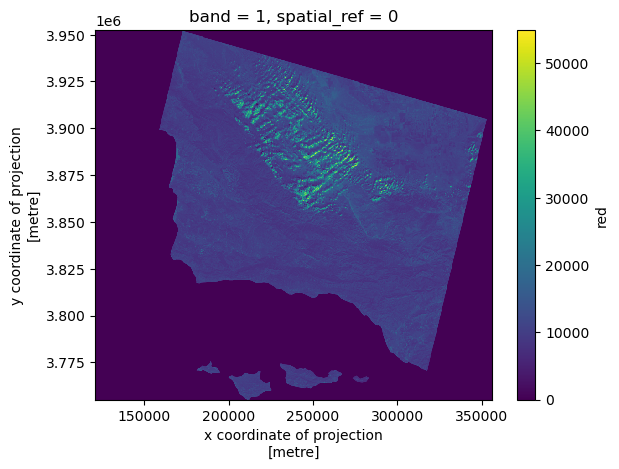

In [20]:
# explore data of the netCDF file

print(f'lsat CRS: {lsat.rio.crs}')

# print shape and data type
print('shape: ', lsat.rio.shape)
print('data type: ', type(lsat), '\n')
# print(lsat)

# make a simple map to visualize lsat dataset
lsat['red'].plot()

⚠️ Notice the following two details:

1. The Coordinate Reference Systems (CRS) of the two datasets are different. Since we want to overlay the Thomas Fire perimeter on the Santa Barbara County land cover, we need to ensure that the CRSs of the two datasets are the same. To achieve this, we will reproject the CRS of the tf dataset into the CRS of the lsat dataset.

2. The lsat dataset includes an additional dimension, the band, which makes it a 3-dimensional object. We are going to convert it into a 2-dimensional dataset by dropping the band dimension.

In [21]:
# drop an extra dimension "band" from lsat dataset
lsat = lsat.squeeze().drop('band')

# check that band dimension has been dropped
print(f'After squeeze:\ndimensions {lsat.dims}\ncoords: {lsat.coords}')

# update CRS of the shape file to lsat CRS
tf = tf.to_crs(crs = lsat.rio.crs)

# check that CRS of the two datasets match
print(f'CRS of the lsat and tf datasets match: {tf.crs == lsat.rio.crs}')

After squeeze:
dimensions Frozen({'y': 731, 'x': 870})
coords: Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
CRS of the lsat and tf datasets match: True


## Create a map <a id="section-9-map"></a>

In the final step we will create a map showing the shortwave infrared/nir/ ed false color image together with the Thomas fire perimeter. 

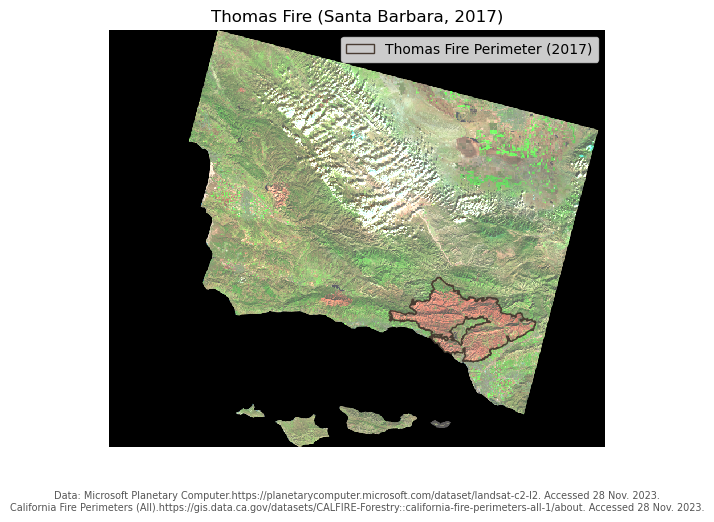

In [22]:
fig, ax = plt.subplots()

# remove axis
ax.axis('off')

# plot Thomas fire perimeter
tf.plot(ax=ax, color='none', edgecolor = '#483C32')
tf_patch = mpatches.Patch(facecolor = 'none', 
                          edgecolor='#483C32', 
                          label='Thomas Fire Perimeter (2017)')

# plot raster image of Santa Barbara area
lsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax, robust = True)

# add legend
ax.legend(handles=[tf_patch], frameon=True, loc='upper right')
ax.set_title('Thomas Fire (Santa Barbara, 2017)')

# Annotate the data source
ax.annotate("Data: Microsoft Planetary Computer.https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.\nCalifornia Fire Perimeters (All).https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023.",
            xy=(0.5, -0.15),  # Move the annotation lower to leave space for the x-axis title
            fontsize=7, 
            xycoords='axes fraction',  
            color='#555555',
            ha='center')  

# Adjust the layout to leave space for the x-axis title
plt.subplots_adjust(bottom=0.01)

# display map
plt.show()